# Conversational Chess

First you need to install the `pyautogen` and `chess` packages to use AutoGen.

In [2]:
! pip install -qqq pyautogen chess

Now you can set up the models you want to use.

In [3]:
import os

config_list = [
    {
        # Choose your model name.
        "model": "gpt-4",
        "api_key": os.environ.get("OPENAI_API_KEY"),
    },
    {
        # Choose your model name.
        "model": "mistral-large-latest",
        "base_url": "https://api.mistral.ai/v1",
        # You need to provide your API key here.
        "api_key": os.environ.get("MISTRAL_API_KEY"),
    }
]

Write function for making a move.

In [4]:
import chess
import chess.svg
from IPython.display import display
from typing import List
from typing_extensions import Annotated

board = chess.Board()

made_move = False

def get_legal_moves() -> Annotated[str, "A list of legal moves in UCI format"]:
    return "Possible moves are: " + ",".join([str(move) for move in board.legal_moves])

def make_move(move: Annotated[str, "A move in UCI format."]) -> Annotated[str, "Result of the move."]:
    move = chess.Move.from_uci(move)
    board.push_uci(str(move))
    global made_move
    made_move = True
    # Display the board.
    display(chess.svg.board(board, arrows=[(move.from_square, move.to_square)], fill={move.from_square: "gray"}, size=200))
    # Get the piece name.
    piece = board.piece_at(move.to_square)
    piece_symbol = piece.unicode_symbol()
    piece_name = chess.piece_name(piece.piece_type).capitalize() if piece_symbol.isupper() else chess.piece_name(piece.piece_type)
    return f"Moved {piece_name} ({piece_symbol}) from {chess.SQUARE_NAMES[move.from_square]} to {chess.SQUARE_NAMES[move.to_square]}."

Let's create the agents. We have three different agents:
- `player_white` is the agent that plays white.
- `player_black` is the agent that plays black.
- `board_proxy` is the agent that moves the pieces on the board.

In [5]:
from autogen import ConversableAgent, register_function

player_white = ConversableAgent(
    name="Player White",
    system_message="You are a chess player and you play as white. "
    "First call get_legal_moves() first, to get list of legal moves. "
    "Then call make_move(move) to make a move.",
    llm_config={"config_list": config_list, "cache_seed": None},
)

player_black = ConversableAgent(
    name="Player Black",
    system_message="You are a chess player and you play as black. "
    "First call get_legal_moves() first, to get list of legal moves. "
    "Then call make_move(move) to make a move.",
    llm_config={"config_list": config_list, "cache_seed": None},
)

def check_made_move(msg):
    global made_move
    if made_move:
        made_move = False
        return True
    else:
        return False

board_proxy = ConversableAgent(
    name="Board Proxy",
    llm_config=False,
    # The board proxy will only terminate the conversation if the player has made a move.
    is_termination_msg=check_made_move,
    default_auto_reply="Please make a move.",
)

Register tools for the agents. See [tutorial chapter on tool use](/docs/tutorial/tool-use) 
for more information.

In [6]:
register_function(
    make_move,
    caller=player_white,
    executor=board_proxy,
    name="make_move",
    description="Call this tool to make a move.",
)

register_function(
    get_legal_moves,
    caller=player_white,
    executor=board_proxy,
    name="get_legal_moves",
    description="Get legal moves.",
)

register_function(
    make_move,
    caller=player_black,
    executor=board_proxy,
    name="make_move",
    description="Call this tool to make a move.",
)

register_function(
    get_legal_moves,
    caller=player_black,
    executor=board_proxy,
    name="get_legal_moves",
    description="Get legal moves.",
)

Register nested chats for the player agents.
Nested chats allows each player agent to chat with the board proxy agent
to make a move, before communicating with the other player agent.
See [nested chats tutorial chapter](/docs/tutorial/conversation-patterns#nested-chats)
for more information.

In [7]:
player_white.register_nested_chats(
    trigger=player_black,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_white,
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_black,
        }
    ],
)

Start the chess game.

Player White (to Player Black):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

Message:
Let's play chess! Your move.

Carryover: 


********************************************************************************
Board Proxy (to Player Black):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

***** Suggested tool Call (call_aiSzuY3fMyTvbQM3cOEwLdyX): get_legal_moves *****
Arguments: 
{}
********************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...
Board Proxy (to Player Black):

Board Proxy

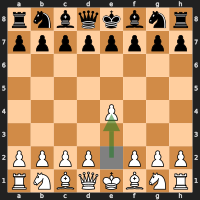

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool "call_1vXlVKZhJh8RYjHWvQP7trM3" *****
Moved pawn (♙) from e2 to e4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

Your move.

--------------------------------------------------------------------------------

>>>>>>>> NO HUMAN INPUT RECEIVED.
Player Black (to Player White):

Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

Message:
Your move.

Carryover: 


********************************************************************************
Board Proxy (to Player White):

Your move.

---------------------------------------------------------------------

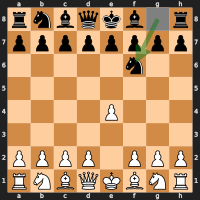

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool "call_AfwFYjJYH6iboNJvQeIijZV6" *****
Moved knight (♞) from g8 to f6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I moved my knight from g8 to f6. Your move.

--------------------------------------------------------------------------------
Player White (to Player Black):

I moved my knight from g8 to f6. Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

Message:
I moved my knight from g8 to f6. Your move.

Carryover: 


********************************************************************************
Board Proxy (to Player Black):

I moved my knig

KeyboardInterrupt: 

In [8]:
# Clear the board.
board = chess.Board()

chat_result = player_white.initiate_chat(
    player_black,
    message="Let's play chess! Your move.",
    max_turns=4,
)